# Processing statistics from probe files

In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Important header information

# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

naluhelperdir = '../../utilities'
sys.path.insert(1, naluhelperdir)
import windspectra
#import yaml as yaml
#from IPython.display import Image
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# Probe file locations
datadir='./spectra/'
probefiletemplates=[
    'l_h1_%05i.dat',
    'l_h2_%05i.dat',
    'l_h3_%05i.dat',
    'l_h4_%05i.dat',
    'l_h5_%05i.dat',
    'l_h6_%05i.dat',
    'l_h7_%05i.dat', 
    'l_h8_%05i.dat', 
    'l_h9_%05i.dat',
    'l_v2_%05i.dat',
    'l_v3_%05i.dat',
    'l_v4_%05i.dat',
    'l_v5_%05i.dat',
    'l_v6_%05i.dat',
    'l_v7_%05i.dat',
    'l_v8_%05i.dat',
    'l_v9_%05i.dat'
]


In [3]:
avgbins    = [[50,600]] 
deltaX     = 2.5
xlocations = np.linspace(-160, 160, 17) 
 #[-160, -120, -80, -40, 0, 40, 80, 120, 160 ]
#print(xlocations)

In [4]:
# Define some dicts to save stuff
Suu_avg={}
Svv_avg={}
Sww_avg={}
avgUlong={}
zavg={}
favg={}
Su_Kai={}
Sv_Kai={}
Sw_Kai={}

In [13]:
# Extract the spectra
for ix, x in enumerate(xlocations):
    print('x = %f'%x)
    # Build the list of probes
    probefiles = [d%ix for d in probefiletemplates]
    #print(probefiles)
    favg[x], Suu_avg[x], Svv_avg[x], Sww_avg[x], avgUlong[x]=windspectra.avgSpectraFiles(probefiles, None, datadir=datadir,
                                                                                         verbose=False,    avgbins=avgbins,
                                                                                         selectfunc=lambda x: x)

x = -160.000000
x = -140.000000
x = -120.000000
x = -100.000000
x = -80.000000
x = -60.000000
x = -40.000000
x = -20.000000
x = 0.000000
x = 20.000000
x = 40.000000
x = 60.000000
x = 80.000000
x = 100.000000
x = 120.000000
x = 140.000000
x = 160.000000


### Load the Mann box turbulence, compute its spectra

In [6]:
filename='turbulence.nc'
ncbox={}
with Dataset(filename) as d:
    #print(d.variables)
    ncbox['ndim'] = d.dimensions['ndim'].size
    ncbox['nx']   = d.dimensions['nx'].size
    ncbox['ny']   = d.dimensions['ny'].size
    ncbox['nz']   = d.dimensions['nz'].size
    ncbox['L']    = d.variables['box_lengths'][:]
    ncbox['dx']   = d.variables['dx'][:]
    ncbox['uvel'] = d.variables['uvel'][:,:,:]
    ncbox['vvel'] = d.variables['vvel'][:,:,:]
    ncbox['wvel'] = d.variables['wvel'][:,:,:]

There are some Gaussian scaling factors used in `SyntheticTurbulence.c`.  
From [Toldberg et al](https://onlinelibrary.wiley.com/doi/full/10.1002/we.1608) equation (10) we have

$$
\mathbf{f}_\epsilon = \mathbf{f}_p \otimes \frac{\eta}{\Delta}
$$
where
$$
\eta(n) = \frac{1}{\epsilon \sqrt{\pi}} \exp \left[ \left( -\frac{n-n_d}{\epsilon} \right)^2 \right]
$$

So the velocity fluctuations will be approximately scaled by
$$
\sqrt{\frac{\eta(0)}{\Delta}}
$$

In [7]:
# Get the timei vector
Uavg = 10.0
tvec = ncbox['dx'][0]/Uavg*np.arange(ncbox['nx'])

# Set the scaling factors
ds=5.0
eps=2.5 #2*ds
gaussScale = 1 #np.sqrt(1.0/(eps*np.sqrt(np.pi)*ds))


In [8]:
# Average over the entire inlet plane of turbulence
Suu = []
Svv = []
Sww = []
itotal = 0
print("Working...")
for i in range(ncbox['ny']):
    sys.stdout.write("\r%d%%" % int(i*100.0/ncbox['ny']))
    sys.stdout.flush()
    for j in range(ncbox['nz']):
        f, tSuu = windspectra.getWindSpectra(tvec, ncbox['uvel'][:,i,j]*gaussScale)
        f, tSvv = windspectra.getWindSpectra(tvec, ncbox['vvel'][:,i,j]*gaussScale)
        f, tSww = windspectra.getWindSpectra(tvec, ncbox['wvel'][:,i,j]*gaussScale)
        Suu = tSuu if len(Suu) == 0 else Suu + tSuu
        Svv = tSuu if len(Svv) == 0 else Svv + tSvv
        Sww = tSuu if len(Sww) == 0 else Sww + tSww
        itotal += 1
Suu = Suu/float(itotal)
Svv = Svv/float(itotal)
Sww = Sww/float(itotal)
print("")
print("Done.")

Working...
99%
Done.


In [9]:
# Octave band average 
Nband=3
Mannf, MannSuu = windspectra.NarrowToOctaveBand(f, Suu, Nband)
Mannf, MannSvv = windspectra.NarrowToOctaveBand(f, Svv, Nband)
Mannf, MannSww = windspectra.NarrowToOctaveBand(f, Sww, Nband)

## Plot Spectra

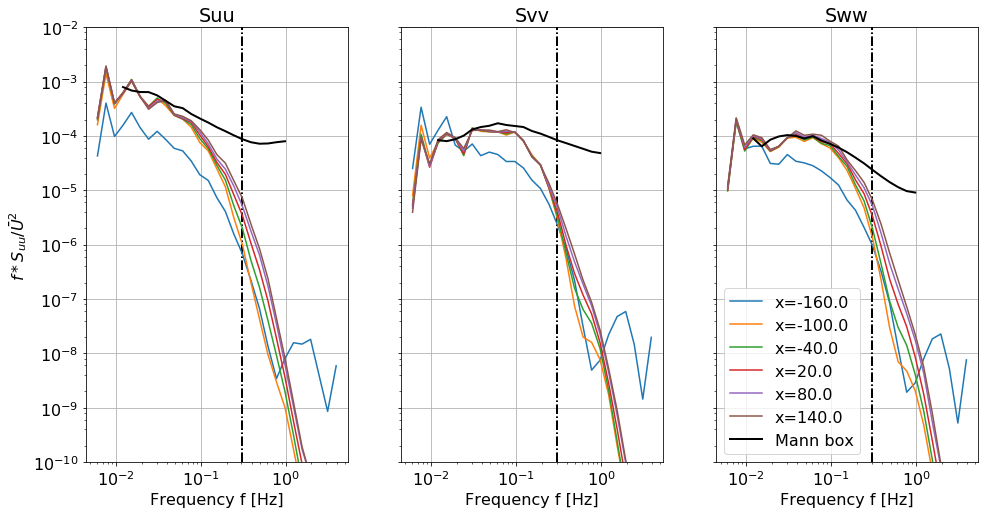

In [14]:
Nband = 3

plt.rc('font', size=16)
fig, axs = plt.subplots(1,3,figsize=(16,8),sharey=True)
for x in xlocations[::3]:
    avgf, avgSuu = windspectra.NarrowToOctaveBand(favg[x], Suu_avg[x], Nband)
    avgf, avgSvv = windspectra.NarrowToOctaveBand(favg[x], Svv_avg[x], Nband)
    avgf, avgSww = windspectra.NarrowToOctaveBand(favg[x], Sww_avg[x], Nband)
    fmax = 0.6*avgUlong[x]/(8*deltaX)
    #print('avgU = %e'%avgUlong[x])
    axs[0].loglog(avgf, avgf*avgSuu/avgUlong[x]**2, label='x=%.1f'%x)
    axs[1].loglog(avgf, avgf*avgSvv/avgUlong[x]**2, label='x=%.1f'%x)
    axs[2].loglog(avgf, avgf*avgSww/avgUlong[x]**2, label='x=%.1f'%x)

axs[0].loglog(Mannf, Mannf*MannSuu/Uavg**2, 'k', lw=2, label='Mann box')
axs[1].loglog(Mannf, Mannf*MannSvv/Uavg**2, 'k', lw=2, label='Mann box')
axs[2].loglog(Mannf, Mannf*MannSww/Uavg**2, 'k', lw=2, label='Mann box')
    
axs[0].set_ylabel(r'$f*S_{uu}/\bar{U}^2$')
axs[0].set_title('Suu')
axs[1].set_title('Svv')
axs[2].set_title('Sww')
    
plt.legend(loc='lower left')
plt.ylim([1E-10, 1E-2])
for i in range(3): 
    axs[i].vlines(fmax, 5e-11, 20,lw=2, linestyle='-.')
    axs[i].set_xlabel('Frequency f [Hz]')
    axs[i].grid()

In [15]:
# Save the spectra
for x in xlocations[:]:
    avgf, avgSuu = windspectra.NarrowToOctaveBand(favg[x], Suu_avg[x], Nband)
    avgf, avgSvv = windspectra.NarrowToOctaveBand(favg[x], Svv_avg[x], Nband)
    avgf, avgSww = windspectra.NarrowToOctaveBand(favg[x], Sww_avg[x], Nband)
    savedat = np.vstack((avgf, avgSuu, avgSvv, avgSww))
    fname   = 'spectra/spectra_%.2f.dat'%(x)
    np.savetxt(fname, savedat.transpose(), header='f avgSuu avgSvv avgSww')

savedat=[[x, avgUlong[x]] for x in xlocations]
np.savetxt('spectra/avgUlong.dat', savedat, header="x avgU")

In [12]:
# compute Reynolds Stress
def computeReStress(filename, selectfunc, argslist, datadir='.'):
    dat       = np.loadtxt(datadir+'/'+filename, skiprows=1)
    ReStressX = np.zeros((len(argslist),3,3))
    for iarg, arg in enumerate(argslist):
        #print('x = %f'%arg)
        filterdat=selectfunc(dat, arg)
        ui=[]
        ui.append(filterdat[:,4])
        ui.append(filterdat[:,5])
        ui.append(filterdat[:,6])
        meanu=np.zeros(3)
        up = np.zeros((3,len(filterdat[:,6])))
        for i in range(3): meanu[i] = np.mean(ui[i])
        for i in range(3): 
            up[i,:] = ui[i]-meanu[i]
        #ReStress = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ReStressX[iarg][i][j] = np.mean(up[i]*up[j])
        #print(meanu)
        #print(ReStress)
    return ReStressX

def AvgReStress(allfiles, selectfunc, argslist, datadir='.'):
    AllReStress = np.zeros((len(argslist),3,3))
    for file in allfiles:
        print('file = '+file)
        ReStress = computeReStress(file, selectfunc, argslist, datadir=datadir)
        AllReStress = AllReStress + ReStress
    AllReStress = AllReStress/float(len(allfiles))
    return AllReStress

#ReStressX=computeReStress(probefiles[0], lambda d,x:  d[d[:,1]==x,:], xlocations, datadir=datadir)

#ReStressX=AvgReStress(probefiles, lambda d,x:  d[d[:,1]==x,:], xlocations, datadir=datadir)

```
plt.figure(figsize=(12,6))
plt.plot(xlocations, ReStressX[:,0,0], label=r'$<u_1 u_1>$')
plt.plot(xlocations, ReStressX[:,1,1], label=r'$<u_2 u_2>$')
plt.plot(xlocations, ReStressX[:,2,2], label=r'$<u_3 u_3>$')
plt.grid()
plt.legend()
plt.xlabel('x [m]')
plt.ylabel(r'$<u_i u_j>$')
plt.title('Avg. Reynolds Stress, all probe files')
plt.ylim([0, 1.5*np.max(ReStressX[:,0,0])]);
#ReStressX[0,:,:]
```

```
plt.figure(figsize=(12,6))
plt.plot(xlocations, ReStressX[:,0,1], label=r'$<u_1 u_2>$')
plt.plot(xlocations, ReStressX[:,0,2], label=r'$<u_1 u_3>$')
plt.plot(xlocations, ReStressX[:,1,2], label=r'$<u_2 u_3>$')
plt.grid()
plt.legend()
plt.xlabel('x [m]')
plt.ylabel(r'$<u_i u_j>$')
plt.title('Avg. Reynolds Stress, all probe files')
max=np.max(ReStressX[:,0,1])
#plt.ylim([-max, max]);
```